# Frequency domain based image steganography

This project hides an image inside another one using a frequency domain based method, the Fourier Transform, which transforms the input images into a frequency domain and merge them, creating an output image. This output image will appear to be just the regular input image, but we can recover the information we put in before by decoding, using a similar method.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import imageio

Would be nice to explain this variables and why this values were choosen.

In [2]:
sector_size = 3 # size of the sector used to embed the secret message
idx = 1 # center of the sector

Here we have some helper functions used to pre-process the image before encoding and post-process to save the output images.

In [3]:
# Convert from RGB or RGBA to HSV
def convertHSV(img):
    return matplotlib.colors.rgb_to_hsv(img[:,:,:3].astype(np.float64))

# Convert from HSV to RGB
def convertRGB(img):
    return matplotlib.colors.hsv_to_rgb(img.astype(np.float64))

# Normalize image
def normalize(img):
    imgMin = np.min(img)
    imgMax = np.max(img)
    return (img-imgMin)/(imgMax-imgMin)

# Get V channel of HSV image with values [0, 1]
def floatV(img):
    return img[:,:,2].astype(np.float64)/255

# Execute modulo operation in a image
def modulo(img, value):
    return (img.astype(np.int64)+value) % value

The functions below are responsible for applying the Fast Fourier Transform and the Inverse Fast Fourier Transform, necessary in the encoding and decoding algorithm

In [4]:
# Apply FFT and shift
def applyFFT(img):
    imgFFT = np.fft.fft2(img)
    return np.fft.fftshift(imgFFT)

# Apply shift and IFFT
def applyIFFT(img):
    imgShift = np.fft.ifftshift(img)
    imgIFFT = np.fft.ifft2(imgShift)
    return imgIFFT

## Encode function

We apply FFT on both images, then we divide the base image into sectors of sector_size x sector_size, defined earlier. On the center of each sector (given by idx), we embed each secret message's frequency value.

Describe why encoding is not possible here.

In [5]:
"""
This function encode a secret image inside a base image,
returning a modified image using the Fast Fourier method.
---
Parameters:
    base -    base image to receive secret message
    secret -  message to be hidden in base image
"""
def encode(base, secret):
    imgBase = applyFFT(np.copy(base))
    height, width = imgBase.shape
    
    imgSecret = applyFFT(secret)
    imgSecretFlat = imgSecret.flatten()
    ind = 0
    
    if((height*width)/sector_size**2 < len(imgSecretFlat)):
        print('Encoding not possible')
        return None
    
    for x in range (0, height-idx, sector_size):
        for y in range (0, width-idx, sector_size):
            if ind < len(imgSecretFlat):
                imgBase[x+idx, y+idx] = imgSecretFlat[ind]
                ind += 1
            else:
                break
    return applyIFFT(imgBase)

## Decode function

Similar to the embedding function, we recover the secret message from the base image that was previously encoded.

In [6]:
"""
This function decode an image, returning the secret 
message embedded using the Fast Fourier method.
---
Parameters:
    img - image with embedded secret
    key - shape of the secret image
"""
def decode(img,key):
    imgBase = applyFFT(img)
    height, width = imgBase.shape
    
    secret_h, secret_w = key
    secret = np.zeros((secret_h*secret_w), dtype=np.complex128)
    ind = 0
    for x in range (0, height-idx, sector_size):
        for y in range (0, width-idx, sector_size):
            if ind < len(secret):
                secret[ind] = imgBase[x+idx, y+idx]
                ind += 1
            else:
                break
    secret = secret.reshape((secret_h,secret_w))
    return applyIFFT(secret)   

##  Test Cases

Input images sources:
   * Windows XP classic wallpaper - https://wallpapercave.com/w/wp2754860
   * Generated QR code - https://www.the-qrcode-generator.com/ (*Read the code to see where it takes you :p*)
   * Flock of birds landscape - https://www.pexels.com/photo/flock-of-birds-917494/
   * Google Chrome T-Rex - https://www.pngwing.com/pt/free-png-xzvzd
   

---

## Windows XP classic wallpaper + random QR code

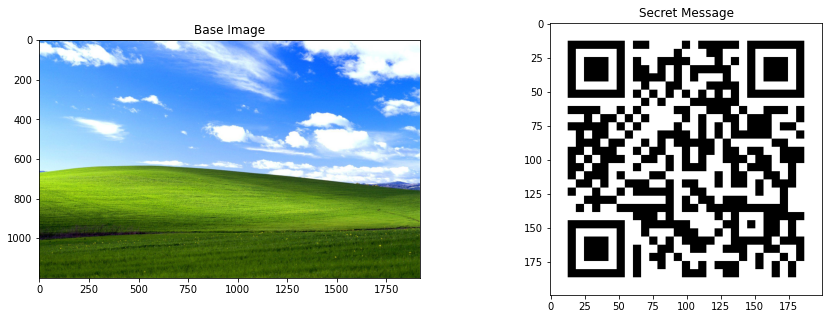

In [7]:
# reading the base image
imgBase = plt.imread('./images/input_windows.jpg')
# reading the secret message
imgSecret = plt.imread('./images/input_qrcode.png')

# plotting images
plt.figure(figsize=(15,5))

ax1 = plt.subplot(121)
ax1.title.set_text('Base Image')
plt.imshow(imgBase)

ax2 = plt.subplot(122)
ax2.title.set_text('Secret Message')
plt.imshow(imgSecret)

### Encoding image

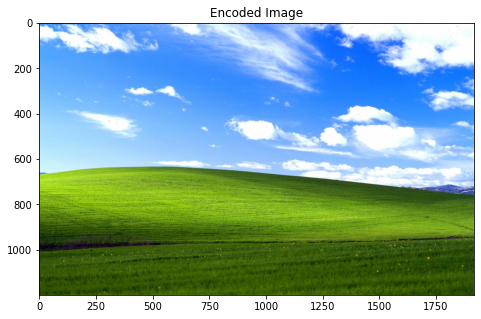

In [8]:
# converting both RGB images to HSV
imgBaseHSV = convertHSV(imgBase)
imgSecretHSV = convertHSV(imgSecret)
    
# extracting V (value attribute) of both HSV images
imgBaseV = floatV(imgBaseHSV)
imgSecretV = floatV(imgSecretHSV)
    
# embedding the secret message
encodedImageV = encode(imgBaseV, imgSecretV).real
    
# replacing the V attribute (updated in encode) in base image
encodedImage = imgBaseHSV
encodedImage[:,:,2] = encodedImageV.astype(np.float64)*255

# converting the image back to RGB and saving the encoded image
finalImage = np.copy(imgBase)
finalImage[:,:,:3] = convertRGB(encodedImage)
imageio.imsave('./images/output_windows_qrcode.png', finalImage)

plt.figure(figsize=(15,5))
ax = plt.subplot(111)
ax.title.set_text('Encoded Image')
plt.imshow(finalImage)

### Decoding image

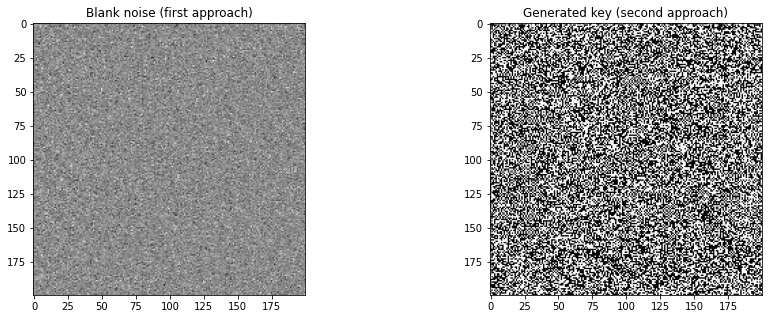

In [9]:
# image used to remove some noise on the encoded image (first approach)
blankImage = np.zeros(imgSecretV.shape)+1
noise = decode(encode(imgBaseV, blankImage).real, imgSecretV.shape).real

# create a decode key from the noise generated (second approach)
finalImageHSV = convertHSV(finalImage)
finalImageV = floatV(finalImageHSV)
noisySecret = decode(finalImageV, imgSecretV.shape).real
key = modulo((noisySecret*255).astype(np.int32)-(imgSecretV*255).astype(np.int32), 256).astype(np.uint8)
imageio.imsave('./images/output_qrcode_key.png', key)

plt.figure(figsize=(15,5))
ax = plt.subplot(121)
ax.title.set_text('Blank noise (first approach)')
plt.imshow(noise, cmap='gray')

ax = plt.subplot(122)
ax.title.set_text('Generated key (second approach)')
plt.imshow(key, cmap='gray')


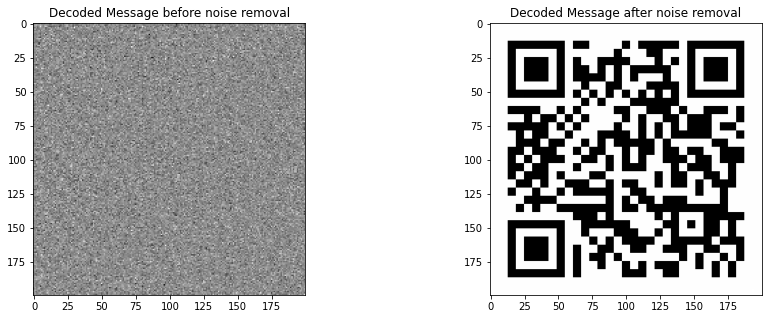

In [10]:
# retrieving the secret message thats embedded on the encoded image using the first approach
secret = decode(encodedImageV, imgSecretV.shape).real
finalSecret = (normalize(secret.real-noise.real)*255).astype(np.uint8)
imageio.imsave('./images/output_qrcode.png', finalSecret)

plt.figure(figsize=(15,5))
ax = plt.subplot(121)
ax.title.set_text('Decoded Message before noise removal')
plt.imshow(secret, cmap="gray")

ax = plt.subplot(122)
ax.title.set_text('Decoded Message after noise removal')
plt.imshow(finalSecret, cmap="gray")

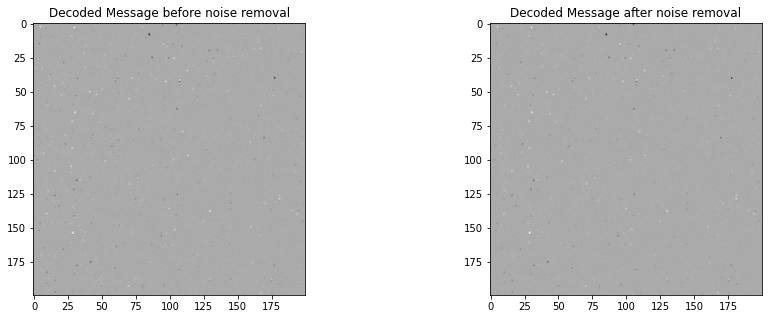

In [11]:
# retrieving the secret message thats embedded on the encoded image using the first approach with saved image
receivedImage = imageio.imread('./images/output_windows_qrcode.png')
receivedImageHSV = convertHSV(receivedImage)
receivedImageV = floatV(receivedImageHSV)

secret = decode(receivedImageV, imgSecretV.shape).real
finalSecret = (normalize(secret.real-noise.real)*255).astype(np.uint8)

plt.figure(figsize=(15,5))
ax = plt.subplot(121)
ax.title.set_text('Decoded Message before noise removal')
plt.imshow(secret, cmap="gray")

ax = plt.subplot(122)
ax.title.set_text('Decoded Message after noise removal')
plt.imshow(finalSecret, cmap="gray")

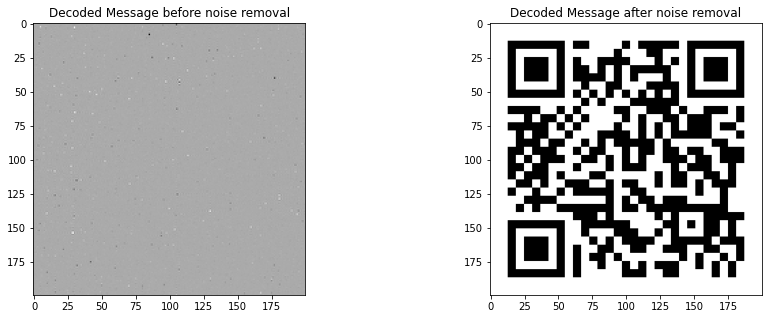

In [12]:
# retrieving the secret message thats embedded on the encoded image using the second approach
receivedImage = imageio.imread('./images/output_windows_qrcode.png')
receivedImageHSV = convertHSV(receivedImage)
receivedImageV = floatV(receivedImageHSV)

receivedKey = imageio.imread('./images/output_qrcode_key.png')

secret = decode(receivedImageV, receivedKey.shape).real
finalSecret = (modulo((secret.real*255).astype(np.int32)-receivedKey, 256)).astype(np.uint8)

plt.figure(figsize=(15,5))
ax = plt.subplot(121)
ax.title.set_text('Decoded Message before noise removal')
plt.imshow(secret, cmap="gray")

ax = plt.subplot(122)
ax.title.set_text('Decoded Message after noise removal')
plt.imshow(finalSecret, cmap="gray")


---

## Flock of birds landscape + Google Chrome T-Rex

### Encoding image

Using a base image with size approximately 5 times bigger than secret image.

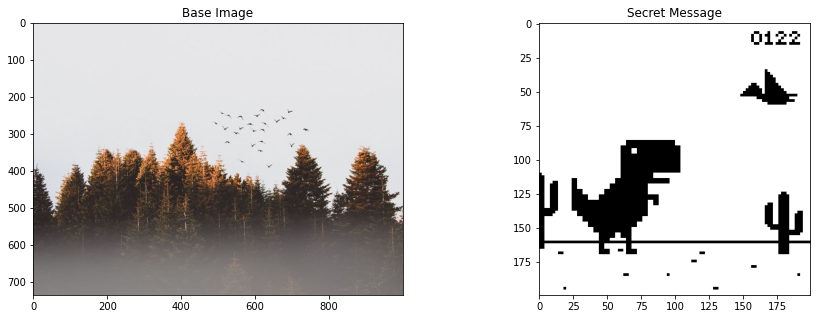

In [13]:
# reading the base image
imgBase = plt.imread('./images/input_trees.jpg')
# reading the secret message
imgSecret = plt.imread('./images/input_trex.png')

# plotting images
plt.figure(figsize=(15,5))

ax1 = plt.subplot(121)
ax1.title.set_text('Base Image')
plt.imshow(imgBase)

ax2 = plt.subplot(122)
ax2.title.set_text('Secret Message')
plt.imshow(imgSecret)

In [14]:
# converting both RGB images to HSV
imgBaseHSV = convertHSV(imgBase)
imgSecretHSV = convertHSV(imgSecret)
    
# extracting V (value attribute) of both HSV images
imgBaseV = floatV(imgBaseHSV)
imgSecretV = floatV(imgSecretHSV)

In [15]:
sector_size = 5

# trying to embedd the secret message
encode(imgBaseV, imgSecretV)

Encoding not possible


With a sector size of 5, is not possible to encode image, because ....

Using a bigger image (approximate size of 3300x2500px) to check how sector size interferes in image degradation.

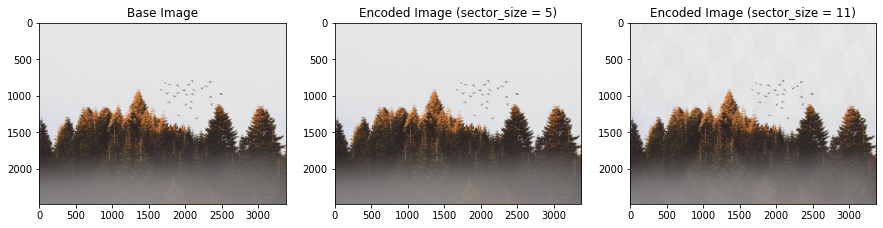

In [16]:
# reading the base image
imgBase = plt.imread('./images/input_trees_big.jpg')

# converting both RGB images to HSV
imgBaseHSV = convertHSV(imgBase)
 
# extracting V (value attribute)
imgBaseV = floatV(imgBaseHSV)

sector_size = 11

# embedding the secret message
encodedImageV = encode(imgBaseV, imgSecretV).real

# replacing the V attribute (updated in encode) in base image
encodedImage = imgBaseHSV
encodedImage[:,:,2] = encodedImageV.astype(np.float64)*255

# converting the image back to RGB and saving the encoded image
finalImage_11 = np.copy(imgBase)
finalImage_11[:,:,:3] = convertRGB(encodedImage)

sector_size = 5

# embedding the secret message
encodedImageV = encode(imgBaseV, imgSecretV).real

# replacing the V attribute (updated in encode) in base image
encodedImage = imgBaseHSV
encodedImage[:,:,2] = encodedImageV.astype(np.float64)*255

# converting the image back to RGB and saving the encoded image
finalImage_5 = np.copy(imgBase)
finalImage_5[:,:,:3] = convertRGB(encodedImage)

# plotting images
plt.figure(figsize=(15,5))

ax1 = plt.subplot(131)
ax1.title.set_text('Base Image')
plt.imshow(imgBase)

ax = plt.subplot(133)
ax.title.set_text('Encoded Image (sector_size = 11)')
plt.imshow(finalImage_11)

ax = plt.subplot(132)
ax.title.set_text('Encoded Image (sector_size = 5)')
plt.imshow(finalImage_5)

### Decoding image

Trying to get the hidden image using the first approach. The final image of the previous case with the best visual result, the one encoded with sector size 5, will be decoded.

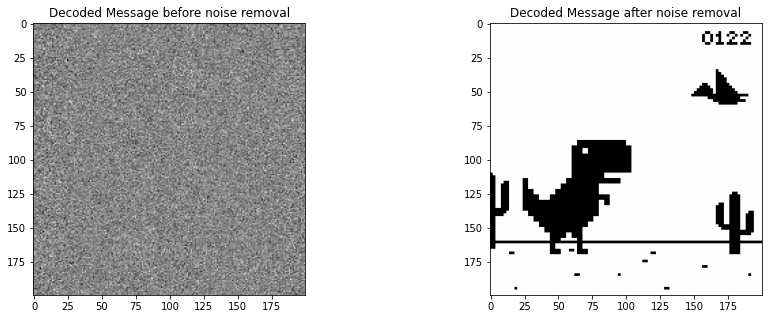

In [17]:
# image used to remove some noise on the encoded image (first approach)
blankImage = np.zeros(imgSecretV.shape)+1
noise = decode(encode(imgBaseV, blankImage).real, imgSecretV.shape).real

# retrieving the secret message thats embedded on the encoded image using the first approach
secret = decode(encodedImageV, imgSecretV.shape).real
finalSecret = (normalize(secret.real-noise.real)*255).astype(np.uint8)

plt.figure(figsize=(15,5))
ax = plt.subplot(121)
ax.title.set_text('Decoded Message before noise removal')
plt.imshow(secret, cmap="gray")

ax = plt.subplot(122)
ax.title.set_text('Decoded Message after noise removal')
plt.imshow(finalSecret, cmap="gray")